In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
from src.model.eegnet_variance import EEGNetMultiHeaded
from src.model.eegnet import EEGNet
from pytorch_lightning.loggers import CometLogger
from src.datamodule import DataModule, predictDataSet
from src.preprocessing import create_dataset
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.preprocessing import *
import pandas as pd
import torch
import shap
from src.model.variance_wrapper import EEGVarianceWrapper, EEGMeanWrapper
from src.plotting import plot_shap_heatmap


c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-ji

Section for visualizing data:

In [4]:
files = get_raw_file_paths('src/pickle_df')

# Load one dataframe
df = pd.read_pickle(files[0])

In [5]:
import torch
torch.cuda.is_available()

True

In [6]:
subjects = 6
sessions = 2
       
trials = [[[[], []]for _ in range(sessions)] for _ in range(subjects)]

for file in files:
    subject = int(file.split('/')[-1][8]) - 1
    session = int(file.split('/')[-1][11]) - 1
    recordings = process_recording(file)

    for recording in zip(recordings[0], recordings[1]):
        if recording[1] == 0:
            trials[subject][session][0].append(recording[0])
        elif recording[1] == 1:
            trials[subject][session][1].append(recording[0])

In [7]:
mean_trials = []

for i, subject in enumerate(trials):
    mean_trials.append([])
    for session in subject:
        mean_trials[i].append((
            np.mean(np.array(session[0]), axis=0),
            np.mean(np.array(session[1]), axis=0)
        ))

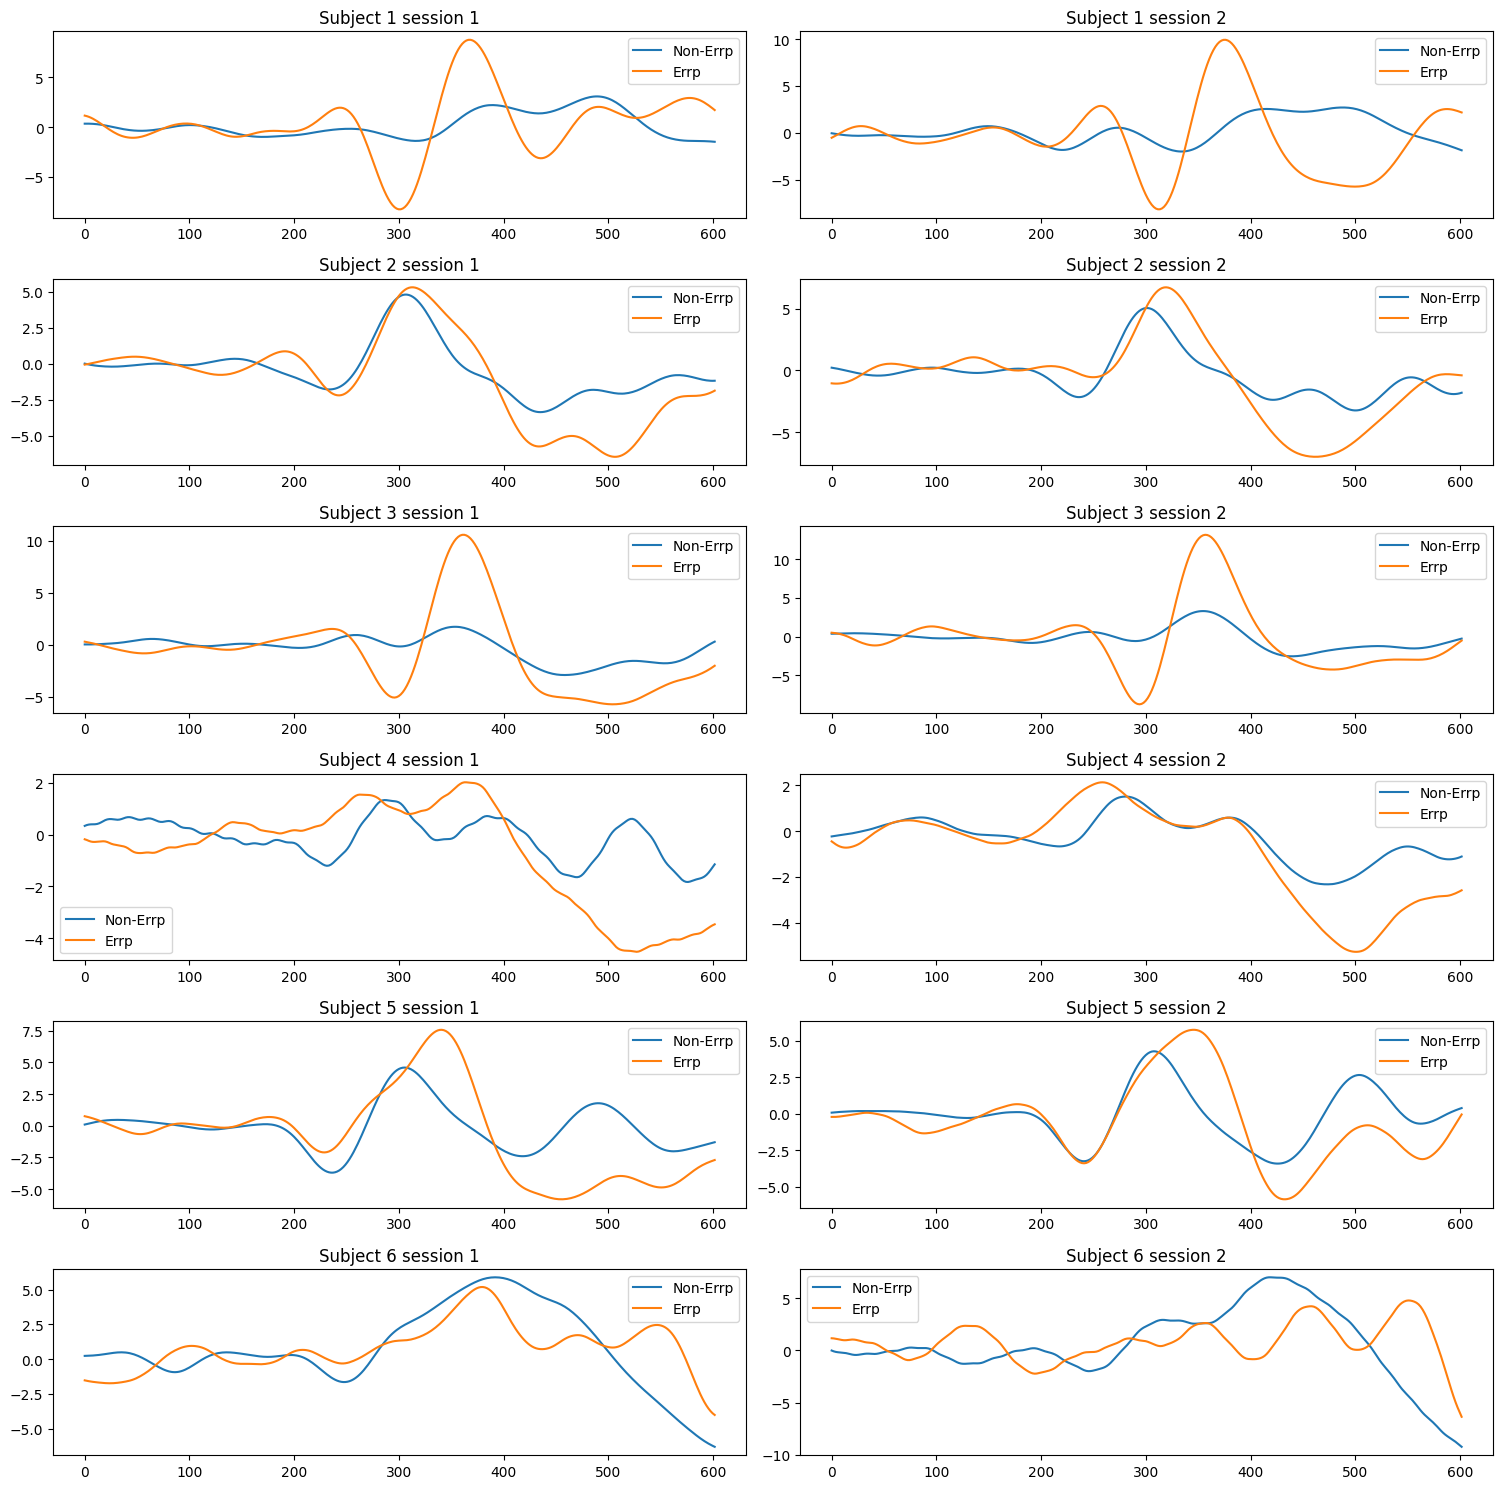

In [8]:
fcz_idx = df.columns.get_loc('FCz')

fcz_len = len(mean_trials[0][0][0][fcz_idx])

duration = fcz_len / 512 * 1000
t = np.linspace(0, duration, fcz_len)

figure, axes = plt.subplots(subjects, sessions, figsize=(15, 15))


for i, subject in enumerate(mean_trials):
    for j, session in enumerate(subject):
        fcz_0 = session[0][fcz_idx]
        fcz_1 = session[1][fcz_idx]

        axes[i, j].plot(t, fcz_0, label='Non-Errp')
        axes[i, j].plot(t, fcz_1, label='Errp')
        axes[i, j].set_title('Subject {subject} session {session}'.format(subject=i + 1, session=j + 1))
        axes[i, j].legend()
       
figure.tight_layout()

Experiment:

In [9]:
comet_logger = CometLogger(
    api_key="WSATCNWE43zphHslQCTsJKcgk",
    workspace="marwo22",  # Optional
    project_name="bachelors-project"  # Optional
)


CometLogger will be initialized in online mode


In [10]:
# Load training module
# The preproccesing code is currently quite messy, still need to clean it up
train, val, test = create_dataset('./src/pickle_df', 1)


Check the distribution of the two classes in the training, validation and testing set

In [11]:
train_count_1 = np.count_nonzero(np.asarray(train[1]))
val_count_1 = np.count_nonzero(np.asarray(val[1]))
test_count_1 = np.count_nonzero(np.asarray(test[1]))

train_count_0 = len(train[1]) - train_count_1
val_count_0 = len(val[1]) - val_count_1
test_count_0 = len(test[1]) - test_count_1

print('Train occurences: Class 0:', train_count_0, 'Class 1:', train_count_1)
print('Validation occurences: Class 0:', val_count_0, 'Class 1:', val_count_1)
print('Test occurences: Class 0:', test_count_0, 'Class 1:', test_count_1)

Train occurences: Class 0: 3448 Class 1: 3448
Validation occurences: Class 0: 858 Class 1: 208
Test occurences: Class 0: 809 Class 1: 235


In [12]:
dm = DataModule(train=train, val=val, test=test, batch_size=16)


In [13]:
model = EEGNetMultiHeaded(chunk_size=308,
                          num_electrodes=64,
                          dropout=0.5,
                          kernel_1=64,
                          kernel_2=16,
                          F1=8,
                          F2=16,
                          D=2,
                          num_classes=2)


In [14]:
trainer = pl.Trainer(
    max_epochs=10,
    logger=comet_logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training and testing the multi-headed variance-predicting model

In [15]:
trainer.fit(model, datamodule=dm)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/e52b246a9f6446429e72782aa65afcdc



The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Epoch 2:  24%|██▍       | 103/431 [00:01<00:03, 88.71it/s, v_num=fcdc]

In [ ]:
trainer.test(datamodule=dm)


`.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\3f7aabf6cdbc430c98bfc63a14c3a937\checkpoints\epoch=9-step=4300.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\3f7aabf6cdbc430c98bfc63a14c3a937\checkpoints\epoch=9-step=4300.ckpt
The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 95.68it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/3f7aabf6cdbc430c98bfc63a14c3a937



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20330416130417736    │
│       incorrect_var       │    0.23270652526277838    │
│         test_acc          │    0.8840996026992798     │
│         test_loss         │     9.672006607055664     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/3f7aabf6cdbc430c98bfc63a14c3a937
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20330416130417736
COMET INFO:     incorrect_var : 0.23270652526277838
COMET INFO:     test_acc      : 0.8840996026992798
COMET INFO:     test_loss     : 9.672006607055664
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 20 metrics, params and output messages


[{'test_acc': 0.8840996026992798,
  'test_loss': 9.672006607055664,
  'correct_var': 0.20330416130417736,
  'incorrect_var': 0.23270652526277838}]

Training the original one-headed model

In [ ]:
test_eeg = test[0]

print(test_eeg[0].shape)
            

(64, 308)


In [ ]:
test_shap = list()

shap_test_tensor = torch.empty((0, 1, 64, 308), dtype=torch.float32)

for (data, _) in dm.test_dataloader():
  shap_test_tensor = torch.cat((shap_test_tensor, data), 0)

background = shap_test_tensor[:-10]
print(background.shape)

torch.Size([1034, 1, 64, 308])


In [ ]:
variance_model = EEGVarianceWrapper(model)
mean_model = EEGMeanWrapper(model)

In [ ]:
e_variance = shap.DeepExplainer(variance_model, background)
e_mean = shap.DeepExplainer(mean_model, background)

In [ ]:
test_list = shap_test_tensor[-5:]
shap_values_variance = e_variance.shap_values(test_list)
shap_values_mean = e_mean.shap_values(test_list)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


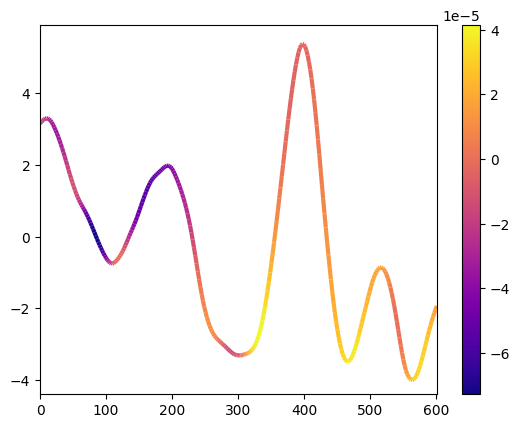

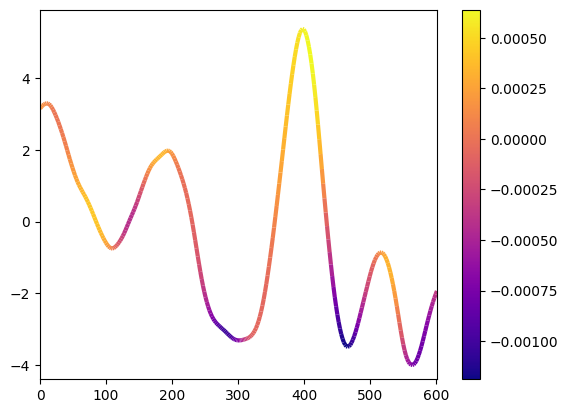

In [ ]:
x = np.linspace(0, 308 / 512 * 1000, 308)
y = test_list.mean(axis=0)[0].mean(axis=0).numpy()

shap_mean_mean = (shap_values_mean[0] + shap_values_mean[1]) / 2
shap_variance_mean = (shap_values_variance[0] + shap_values_variance[1]) / 2
z_mean = shap_mean_mean.mean(axis=0)[0].mean(axis=0)
z_variance = shap_variance_mean.mean(axis=0)[0].mean(axis=0)

plot_shap_heatmap(x, y, z_mean, cmap='plasma')
plot_shap_heatmap(x, y, z_variance, cmap='plasma')

In [ ]:
shap_variance_mean
shap_variance_channels = shap_variance_mean.mean(axis=0)[0].mean(axis=1)

NameError: name 'shap_variance_mean' is not defined

Test runs (10 epochs)

Subject 1
COMET INFO:     correct_var   : 0.24526300002277765
COMET INFO:     incorrect_var : 0.2487000952699538
COMET INFO:     test_acc      : 0.7383260130882263
COMET INFO:     test_loss     : 3.219019651412964

Subject 2
COMET INFO:     correct_var   : 0.2260321459501493
COMET INFO:     incorrect_var : 0.23518400635999237
COMET INFO:     test_acc      : 0.6910856366157532
COMET INFO:     test_loss     : 3.2498958110809326

Subject 3
COMET INFO:     correct_var   : 0.22918819762528056
COMET INFO:     incorrect_var : 0.23405312742954087
COMET INFO:     test_acc      : 0.6031163930892944
COMET INFO:     test_loss     : 3.429486036300659

Subject 4
COMET INFO:     correct_var   : 0.21242563703894976
COMET INFO:     incorrect_var : 0.22683236699740444
COMET INFO:     test_acc      : 0.8202348947525024
COMET INFO:     test_loss     : 2.9433605670928955

Subject 5
COMET INFO:     correct_var   : 0.2306651021589556
COMET INFO:     incorrect_var : 0.2371705954791413
COMET INFO:     test_acc      : 0.774449348449707
COMET INFO:     test_loss     : 3.1388168334960938

Subject 6
COMET INFO:     correct_var   : 0.21972788197611084
COMET INFO:     incorrect_var : 0.2156169066196063
COMET INFO:     test_acc      : 0.5225631594657898
COMET INFO:     test_loss     : 4.015593528747559




Average 0.692 test_acc

Plan for experiment:

- First, check the overall predictive performance of the model, by making a confusion matrix and ROC curve. Either one for each test-subject, or one on average
- Check if reducing the resolution to 128hz improves performance
- Plot a histogram of the variances (done)
- Create a graph with the effect of label shuffling on the average variance (done)
- Run a test with Shap approximation on the LABEL head, to see which parts of the input contribute the most to the prediction. Then see if zeroing or adding noise to these areas results in higher average variance, than doing it on a part which contributes less
- Run a test with Shap approximation on the VARIANCE head, and see which parts contribute the most. Now, check if zeroing/adding noise creates a shift in this approximation.
- Finding a way to train/test on artificial physiological artefacts would be preferable, but not feasable for this project
- Plot coverage/accuracy plot with cutoff



- Noisy data should result in a higher uncertainty
- Noise in areas which show high influence on prediction should give a higher increase in influence than non-important parts
- Adding noise to specific areas should result in a shift in the uncertainty contribution


- Only thing I am not sure about yet is to what extend the data should be corrupted. I'll have to come up with a good distribution of normal/corrupted training episodes.
- Plan on how to corrupt data: 